## Downloading the required files/packages to make the system ready for using CUDA GPU

In [ ]:
!nvidia-smi

In [ ]:
!pip install cudf-cu11 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.4/506.4 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 101.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.4/582.4 kB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 118.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 101.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 18.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 413, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 413 (delta 103), reused 58 (delta 54), pack-reused 269
Receiving objects: 100% (413/413), 113.29 KiB | 5.39 MiB/s, done.
Resolving deltas: 100% (205/205), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.2 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla V100-SXM2-16GB!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 723.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import cudf
%load_ext cudf.pandas

import cuml
import cugraph
import cuspatial
import cuxfilter
import time
import numpy as np
import cupy as cp
from cuml.datasets import make_regression
from cuml.model_selection import train_test_split, GridSearchCV
from cuml.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score
from cuml.linear_model import LinearRegression, Lasso
import matplotlib.pyplot as plt

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

## Extracting the csv file into a CUDA Dataframe

In [ ]:
!gunzip 2022.csv.gz

In [ ]:
#Note for taking the preprocessing time and storing it

import time
import cudf
import numpy as np

start_time = time.time()

# Read the CSV file into a cuDF DataFrame along with the required Columns
cols = ["ID", "date", "ELEMENT", "READING", "M", "Q", "S", "time"]
df2 = cudf.read_csv('2022.csv', header=None, names=cols, nrows=25000000)

#Drop the rows where 'Q' column is NaN, ie the entry did not pass the quality check
df2 = df2[df2['Q'].isna()]

#Need only these rows (Shown in the Data Exploration from the Serial python notebook)
desired_elements = ['PRCP', 'SNOW', 'TMIN', 'TMAX', 'TAVG', 'SNWD']

#Filtering the rows where 'ELEMENT' is in the desired_elements list
df2 = df2[df2['ELEMENT'].isin(desired_elements)]

#Convert 'date' column to datetime from integer
df2['date'] = cudf.to_datetime(df2['date'], format='%Y%m%d')

#Pivoting the table to make contents of ELEMENT as new individual columns
df2 = df2.pivot_table(index=['ID', 'date'], columns=['ELEMENT'], values='READING', aggfunc='mean').reset_index()

#Fill missing value with 0 (initially tried interpolation, mean,median but did not get a good output)
df2[desired_elements].fillna(0, inplace=True)

#Storing the program run time and displaying for conversion
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 7.534266948699951 seconds


In [ ]:
df2

## Linear Regression

In [ ]:
start_time = time.time()

#Taking the required features as test and target from our dataframe
X = df2[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']]
y = df2['TAVG']

#Split the dataset into training, validation, and testing sets
#Total 100; (70% training, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

#Linear Regression initialization from the cuML library
linear_reg_model = LinearRegression()

#Training the Linear Model
linear_reg_model.fit(X_train, y_train)

#Prediction on the validation data set
linear_reg_preds_val = linear_reg_model.predict(X_val)

#Calculating the R^2 score on the validation set for Linear Regression
r2_val_linear_reg = r2_score(cp.asnumpy(y_val), cp.asnumpy(linear_reg_preds_val))
print("Linear Regression R^2 on Validation Set:", r2_val_linear_reg)

#Lasso Regression with Hyperparameter Tuning values declaration
lasso_param_grid = {'alpha': [0.1, 1, 2, 5, 10, 15, 20, 25, 30]}
lasso_model = Lasso()

#Performing GridSearchCV for hyperparameter tuning for Lasso Regression
lasso_grid_search = GridSearchCV(lasso_model, lasso_param_grid, cv=5)

#Training the Lasso Regression model
lasso_grid_search.fit(X_train, y_train)

#Storing the best parameters
best_lasso_params = lasso_grid_search.best_params_

#Training the Lasso model on the training data using the best hyperparameters
best_lasso_model = Lasso(**best_lasso_params)
trained_lasso = best_lasso_model.fit(X_train, y_train)

#Predicting the values on the validation set
lasso_val_preds = trained_lasso.predict(X_val)

#Calculating th eR^2 score on the validation set for Lasso Regression
r2_val_lasso = r2_score(cp.asnumpy(y_val), cp.asnumpy(lasso_val_preds))
print("Lasso Regression R^2 on Validation Set:", r2_val_lasso)

#Measuring and displaying the execution time for comparision
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Linear Regression R^2 on Validation Set: 0.3263754642452853
Lasso Regression R^2 on Validation Set: 0.3263749663000566
Execution time: 12.25532841682434 seconds


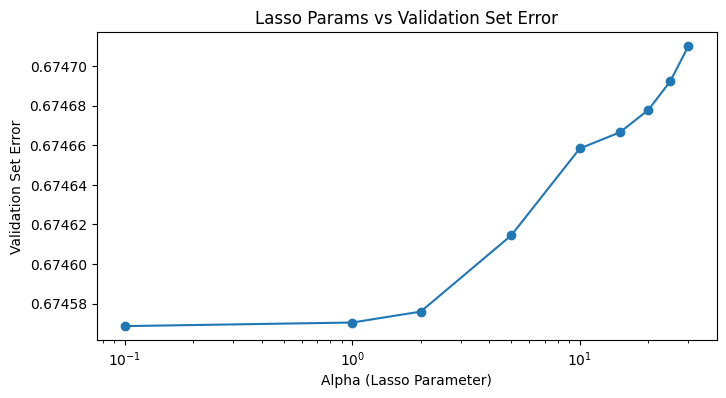

In [ ]:
#Plotting the Lasso Params vs Validation Set Error to visualize all the hyperparameters (Lambda Values)
lasso_errors = [1 - x for x in lasso_grid_search.cv_results_['mean_test_score']]
plt.figure(figsize=(8, 4))
plt.plot(lasso_param_grid['alpha'], lasso_errors, marker='o')
plt.title('Lasso Params vs Validation Set Error')
plt.xlabel('Alpha (Lasso Parameter)')
plt.ylabel('Validation Set Error')
plt.xscale('log')
plt.show()

## Neural Network

In [ ]:
#Importing all the required libraries for Neural Network computation

import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import altair as alt
import seaborn as sns
from sklearn.cluster import KMeans

In [ ]:
#Some preprocessing and recalculation of the pandas dataframe was required
#as the CUDA dataframe v/s PANDAS dataframe was throwing errors while computation

#Storing values of the csv file
cols=["ID","date","ELEMENT","READING","M","Q","S","time"]
df2=pd.read_csv("2022.csv",header=None,names=cols,nrows = 25000000)

#Discarding rows failing the quality check
df2 = df2[pd.isna(df2['Q'])]

#Taking the desired elements
desired_elements = ['PRCP', 'SNOW', 'TMIN', 'TMAX', 'TAVG', 'SNWD']

df2 = df2[df2['ELEMENT'].isin(desired_elements)]
df2['date'] = pd.to_datetime(df2['date'], format='%Y%m%d', errors='coerce')

#Pivoting the table to make ELEMENTS unique values as columns
df2=df2.pivot_table(index=['ID', 'date'], columns='ELEMENT', values='READING').reset_index()

#Filling empty values with 0
df2[desired_elements] = df2[desired_elements].fillna(0)

In [ ]:
#Noting the time the Neural Network takes for 5 epochs
start_time = time.time()

#Spliting the data into features (X) and target variable (y)
X = df2[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']]
y = df2['TAVG']

#Split of the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standardizing the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Split the training data into training and validation sets
#Total 100 (20% Testing; 16% Validation; 64% Training)
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)


#Creating the Neural Network the model
model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

#Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')


###Taken from the serial computation python notebook###

#Training the model and storing the training
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64, validation_split=0.2)

#Evaluating the model on the test set (No validation in Neural Networks)
loss = model.evaluate(X_test_scaled, y_test)

#Prediction of the target variable on the test set
y_pred = model.predict(X_test_scaled)

#Calculating mean squared error for the Neural Network
mae = mean_absolute_error(y_test, y_pred)

#Predicting the r2 score for Regression analysis
r2 = r2_score(y_test, y_pred)

#Noting the ending time
end_time = time.time()
execution_time = end_time - start_time

Epoch 1/10
64427/64427 [==============================] - 272s 4ms/step - loss: 3101.9397 - val_loss: 3025.0918
Epoch 2/10
64427/64427 [==============================] - 277s 4ms/step - loss: 3004.3923 - val_loss: 2992.3945
Epoch 3/10
64427/64427 [==============================] - 276s 4ms/step - loss: 2987.7849 - val_loss: 2994.1062
Epoch 4/10
64427/64427 [==============================] - 263s 4ms/step - loss: 2980.9214 - val_loss: 2982.3965
Epoch 5/10
64427/64427 [==============================] - 258s 4ms/step - loss: 2976.7341 - val_loss: 2979.6484
Epoch 6/10
64427/64427 [==============================] - 259s 4ms/step - loss: 2973.3804 - val_loss: 2982.5798
Epoch 7/10
64427/64427 [==============================] - 273s 4ms/step - loss: 2971.2893 - val_loss: 2977.4170
Epoch 8/10
64427/64427 [==============================] - 259s 4ms/step - loss: 2969.0659 - val_loss: 2977.7812
Epoch 9/10
64427/64427 [==============================] - 272s 4ms/step - loss: 2967.2642 - val_loss: 29

In [ ]:
#Printing all the data from the above cell
#Printed values: Mean Absolute Error, r2 value, Total Execution time

print(f"Mean Absolute Error on Test Set: {mae}")
print()
print(f"R-squared on Test Set: {r2}")
print()
print(f"Execution time for Neural Network: {execution_time} seconds")

Mean Absolute Error on Test Set: 27.646202479213677

R-squared on Test Set: 0.45372557163174554

Execution time for Neural Network: 2937.7589247226715 seconds


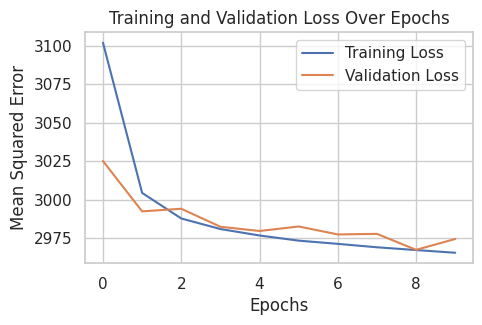

In [ ]:
# Plotting the training and validation loss v/s epochs
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

## K Means Clustering

In [ ]:
#Importing required libraries from CUDA dataframe and pandas df etc

import cudf
import time
import numpy as np
import pandas as pd
from cuml import KMeans
from cuml.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#K Means Preprocessing
start_time = time.time()

#Declaring the headings of the columns in the csv file and storing them in df2
cols=["ID","date","ELEMENT","READING","M","Q","S","time"]
df2=pd.read_csv("2022.csv",header=None,names=cols,nrows=25000000)

#Taking only the features we need
selected_features = ['TMIN', 'TMAX', 'SNOW','PRCP','SNWD']
df2 = df2[df2['ELEMENT'].isin(selected_features)]

#Discarding all entries which failed the Quality Check
df2 = df2[df2['Q'].isna()]

#Dropping the columns which we do not need
dropthese=['Q','S','M','time']
df2=df2.drop(columns=dropthese)

df2=df2.reset_index()

#Pivoting the table (Similar to One Hot Encoding)
selected_features = ['TMIN', 'TMAX', 'SNOW','PRCP','SNWD']
df2=df2.pivot_table(index=['ID', 'date'], columns='ELEMENT', values='READING').reset_index()

#Dropping the rows which have any value blank, as empty values reduce performance of K Means Clustering
df2=df2.dropna(subset=selected_features, how='any')

#Conversion of date from integer to date format
df2['date'] = pd.to_datetime(df2['date'], format='%Y%m%d', errors='coerce')

groupeddf=df2.reset_index()
groupeddf=groupeddf.drop('index',axis=1)

#Declaring the columns of the other csv file named "Stations"
cols=["ID","LATITUDE","LONGITUDE","ELEVATION","STATE","NAME","GSN","HCN","WMO"]
df=pd.read_csv("Station.csv",header=None, names=cols)

#Calculating the total run time of the entire program
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 30.614681005477905 seconds


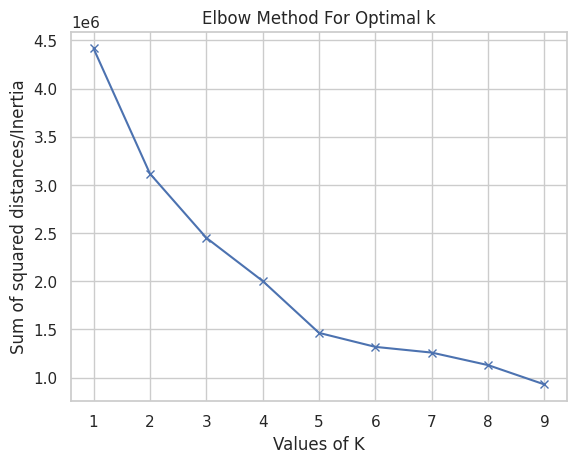


Execution time: 2.5513598918914795 seconds


In [ ]:
#K Means Preprocessing
start_time = time.time()

#Normalizing the data for K Means
scaler=StandardScaler()

#Performing the WCSS (Elbow Method) to find the best value of K
#Declaring data structures needed, method(s)
sumsquared=[]
feature_scaled=scaler.fit_transform(groupeddf.drop(['ID','date'],axis=1))
groupeddf['cluster']=np.nan
k=range(1,10)
for num_clusters in k:
  kmeans=KMeans(n_clusters=num_clusters, random_state=42)
  kmeans.fit(feature_scaled)
  sumsquared.append(kmeans.inertia_)


#Visualizing the WCSS to see which K value we should take
plt.plot(k,sumsquared,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances/Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()
print()

#K=4 came out to be the best value of 'K', hence we perform KMeans
k=4
kmeans=KMeans(n_clusters=k, random_state=42)
groupeddf['cluster']=kmeans.fit_predict(feature_scaled)

#Merging both the files in order to get the latitude and longitude co-ordinates
merged_df = pd.merge(groupeddf,df, on='ID', how='inner')

#Calculating the total run time of the entire program
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

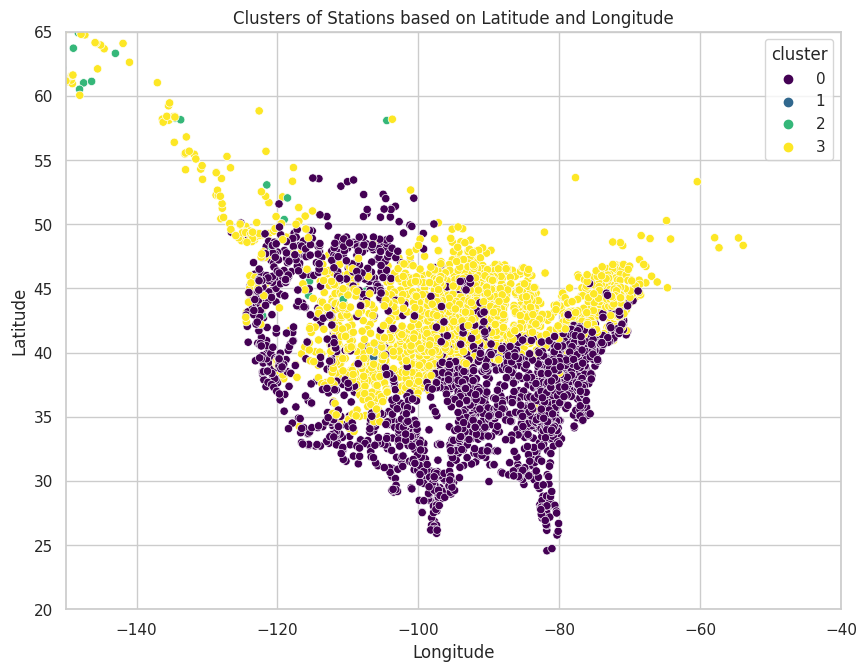

In [ ]:
#Visualization of the station along with their cluster color (Stations with the same cluster have similar climates)
#Setting seaborn style
sns.set(style="whitegrid")

#Creating a scatter plot with clusters colored differently
plt.figure(figsize=(10,7.5))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='cluster', palette='viridis', data=merged_df[merged_df['date'] == '2022-05-05'])
#NOTE: This graph shows similar locations for the date: 5th May 2022
#We cropped the graph so that it focuses on the United States latitude & longitude
#as there were very less stations outside the US
plt.xlim((-150,-40))
plt.ylim((20,65))
plt.title('Clusters of Stations based on Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Archieved kept just in case, other wise code has ended here ^^

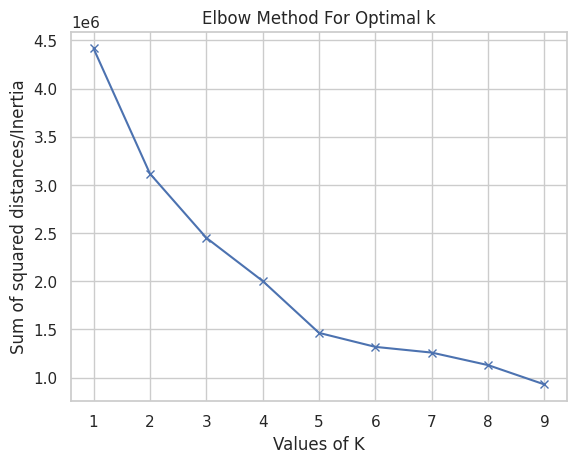

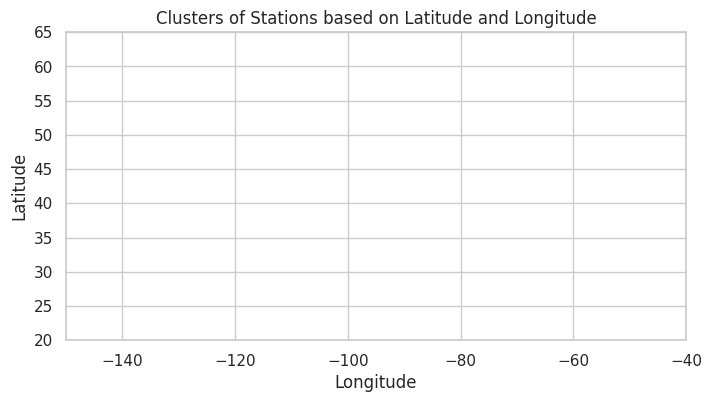

In [ ]:
# start_time = time.time()

# #Reading the CSV file and storing the header column as a list
# cols = ["ID", "date", "ELEMENT", "READING", "M", "Q", "S", "time"]
# df2 = pd.read_csv("2022.csv", header=None, names=cols, nrows=25000000)

# #Filtering selected features based upon data exploration
# selected_features = ['TMIN', 'TMAX', 'SNOW', 'PRCP', 'SNWD']
# df2 = df2[df2['ELEMENT'].isin(selected_features)]

# #Discarding entries failing the quality check
# df2 = df2[df2['Q'].isna()]

# #Dropping unnecessary columns
# dropthese = ['Q', 'S', 'M', 'time']
# df2 = df2.drop(columns=dropthese).reset_index()

# #Pivoting the table
# df2 = df2.pivot_table(index=['ID', 'date'], columns='ELEMENT', values='READING').reset_index()

# #Dropping rows with any blank values to prevent our model performance to detoriate
# df2 = df2.dropna(subset=selected_features, how='any')

# #Converting date to datetime from its original integer value
# df2['date'] = pd.to_datetime(df2['date'], format='%Y%m%d', errors='coerce')

# #Normalizing data for K Means using RAPIDS AI
# scaler = StandardScaler()
# feature_scaled = scaler.fit_transform(df2.drop(['ID', 'date'], axis=1))

# #Performing the WCSS (Elbow Method) to find the best value of K using RAPIDS
# sumsquared = []
# k = range(1, 10)
# for num_clusters in k:
#     kmeans = KMeans(n_clusters=num_clusters, random_state=42)
#     kmeans.fit(feature_scaled)
#     sumsquared.append(kmeans.inertia_)

# #Visualize the WCSS to determine the optimal K value
# plt.plot(k, sumsquared, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Sum of squared distances/Inertia')
# plt.title('Elbow Method For Optimal k')
# plt.show()
# print()

# #Choose K = 4 as the optimal value and performing K Means clustering
# k = 4
# kmeans = KMeans(n_clusters=k, random_state=42)
# df2['cluster'] = kmeans.fit_predict(feature_scaled)

# #Reading the station data from the csv file
# cols = ["ID", "LATITUDE", "LONGITUDE", "ELEVATION", "STATE", "NAME", "GSN", "HCN", "WMO"]
# df = pd.read_csv("Station.csv", header=None, names=cols)

# #Merge both 2022 climate and station details dataframes
# merged_df = pd.merge(df2, df, on='ID', how='inner')

# #Setting seaborn style
# sns.set(style="whitegrid")

# #Creating a scatter plot with clusters colored differently
# plt.figure(figsize=(8,4))
# sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='cluster', palette='viridis', data=merged_df[merged_df['date'] == '2022-01-01'])
# plt.xlim((-150, -40))
# plt.ylim((20, 65))
# plt.title('Clusters of Stations based on Latitude and Longitude')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()

# #Storing the end time of the program
# end_time = time.time()
# execution_time = end_time - start_time

In [ ]:
#Printing total program execution time
print(f"Execution time: {execution_time} seconds")

Execution time: 34.74276351928711 seconds
